In [7]:
import os
import zipfile

import numpy as np
import pandas as pd
from pandas import DataFrame
from scipy.stats.mstats import winsorize
import matplotlib.pyplot as plt
from scipy import stats

from Constant import Constants as const

# Draw annual trend

In [2]:
KX_path = r'D:\Onedrive\Projects\CapitalControl\data\KarXiong'
er_guarantee_df: DataFrame = pd.read_csv(os.path.join(KX_path, '240816_firm_year_level_data.csv'), 
                                         usecols=['Symbol', 'Year', 'TotalLoan', 'NumGuarantee']).rename(columns={"Symbol": const.TICKER, 'Year': const.YEAR})

In [3]:
df = er_guarantee_df.loc[er_guarantee_df[const.YEAR].apply(lambda x: 2010 <= x <= 2018)].groupby(const.YEAR).sum()

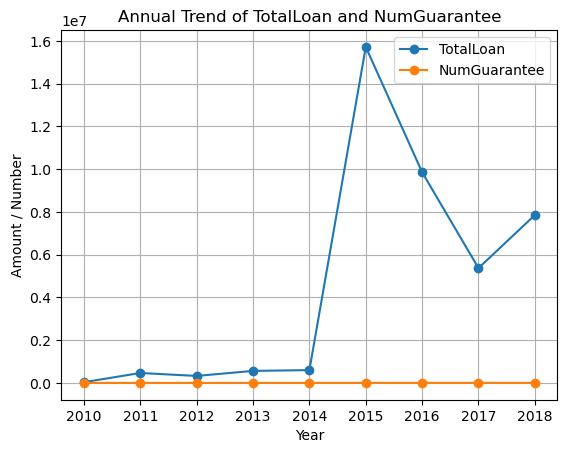

In [8]:


# Plot TotalLoan
plt.plot(df.index, df['TotalLoan'], marker='o', linestyle='-', label='TotalLoan')

# Plot NumGuarantee
plt.plot(df.index, df['NumGuarantee'], marker='o', linestyle='-', label='NumGuarantee')

# Adding labels and legend
plt.xlabel('Year')
plt.ylabel('Amount / Number')
plt.title('Annual Trend of TotalLoan and NumGuarantee')
plt.legend()
plt.grid(True)

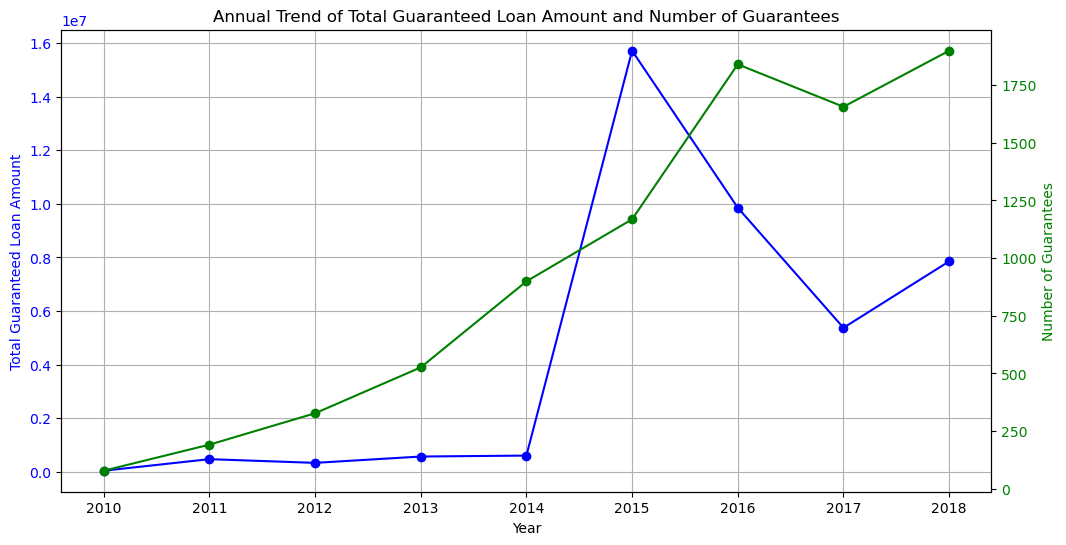

In [6]:
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot TotalLoan on the left y-axis
ax1.plot(df.index, df['TotalLoan'], marker='o', linestyle='-', color='b', label='Total Guaranteed Loan Amount')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Guaranteed Loan Amount', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Create a second y-axis for NumGuarantee
ax2 = ax1.twinx()
ax2.plot(df.index, df['NumGuarantee'], marker='o', linestyle='-', color='g', label='Number of Guarantees')
ax2.set_ylabel('Number of Guarantees', color='g')
ax2.tick_params(axis='y', labelcolor='g')

# Adding the title
plt.title('Annual Trend of Total Guaranteed Loan Amount and Number of Guarantees')

plt.savefig(os.path.join(const.REGRESSION_RESULT_PATH, '20241027', 'DGFL_trends.png'))

# Displaying the plot
plt.show()

# Generate Pre and post data code

In [10]:
# Sample data loading (replace with actual data loading code)
data = pd.read_stata(os.path.join(const.OUTPUT_PATH, '20241027_cc_reg_data.dta'))

# Filtering pre and post periods
data_pre = data[data['year'] < 2014]
data_post = data[data['year'] >= 2014]

# Define the treated and control groups
treated_pre = data_pre[data_pre['has_guarantee'] == 1]
control_pre = data_pre[data_pre['has_guarantee'] == 0]
treated_post = data_post[data_post['has_guarantee'] == 1]
control_post = data_post[data_post['has_guarantee'] == 0]

# List of variables to compare
variables = ['CAPEX_lat_1', 'CAPEX_RDI_lat_1', 'size', 'TobinQ', 'OCF_lat', 'soe', 'lev', 'top1', 'sale_growth']

# Function to calculate the mean, median, N, and t-test
def compare_groups(treated, control, variable):
    treated_mean = treated[variable].mean()
    treated_median = treated[variable].median()
    treated_n = treated[variable].count()
    
    control_mean = control[variable].mean()
    control_median = control[variable].median()
    control_n = control[variable].count()
    
    difference = treated_mean - control_mean
    t_stat, p_value = stats.ttest_ind(treated[variable].dropna(), control[variable].dropna(), equal_var=False)
    
    significance = ''
    if p_value < 0.01:
        significance = '***'
    elif p_value < 0.05:
        significance = '**'
    elif p_value < 0.1:
        significance = '*'
    
    return round(treated_mean, 4), round(treated_median, 4), treated_n, round(control_mean, 4), round(control_median, 4), control_n, round(difference, 4), f'({round(p_value, 4)})', significance

# Creating summary tables for pre and post periods
summary_pre = []
summary_post = []

for var in variables:
    # Pre-period comparison
    treated_mean, treated_median, treated_n, control_mean, control_median, control_n, difference, p_value, significance = compare_groups(treated_pre, control_pre, var)
    summary_pre.append([var, treated_mean, treated_median, treated_n, control_mean, control_median, control_n, difference, p_value, significance])
    
    # Post-period comparison
    treated_mean, treated_median, treated_n, control_mean, control_median, control_n, difference, p_value, significance = compare_groups(treated_post, control_post, var)
    summary_post.append([var, treated_mean, treated_median, treated_n, control_mean, control_median, control_n, difference, p_value, significance])

# Convert summaries to DataFrames
columns = ['Variable', 'Treated Mean', 'Treated Median', 'Treated N', 'Control Mean', 'Control Median', 'Control N', 'Difference', 'p-value', 'Significance']
summary_pre_df = pd.DataFrame(summary_pre, columns=columns)
summary_post_df = pd.DataFrame(summary_post, columns=columns)

# Display results
print("Panel A: Pre-Event Period")
print(summary_pre_df)
print("\nPanel B: Post-Event Period")
print(summary_post_df)

Panel A: Pre-Event Period
          Variable  Treated Mean  Treated Median  Treated N  Control Mean  \
0      CAPEX_lat_1      0.067300          0.0567        335        0.0698   
1  CAPEX_RDI_lat_1      0.068300          0.0574        335        0.0706   
2             size     22.863701         22.7175        337       21.6689   
3           TobinQ      1.609400          1.3138        329        1.9222   
4          OCF_lat      0.034200          0.0404        332        0.0507   
5              soe      0.394400          0.0000        322        0.5052   
6              lev      0.532000          0.5532        337        0.4814   
7             top1     37.033800         35.4150        334       36.3926   
8      sale_growth      0.113700          0.0754        329        0.1139   

   Control Median  Control N  Difference   p-value Significance  
0          0.0453      16275     -0.0025  (0.4333)               
1          0.0461      16275     -0.0023  (0.4817)               
2    

In [11]:
summary_pre_df.to_excel(os.path.join(const.REGRESSION_RESULT_PATH, '20241027', 'summary_pre.xlsx'))
summary_post_df.to_excel(os.path.join(const.REGRESSION_RESULT_PATH, '20241027', 'summary_post.xlsx'))